In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import bps
from bps import generate_bps_ngrid
import torch
import numpy as np
import matplotlib.pyplot as plt

In [46]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

In [48]:
grid = grid_list[5]
basis = generate_bps_ngrid(16, 2, minv=0, maxv=63)
full, empty = bps.create_scene_point_cloud(grid, create_empty_cloud=True)

bps_encoding = bps.encode_scene(full, basis, "scalar", "none", empty, grid_shape_for_grid_basis=(16,16))

In [49]:
bps_encoding.shape

(16, 16)

In [50]:
def reconstruct_from_bps(bps_grid, basis_pts, output_grid_length):
    H = output_grid_length
    W = output_grid_length
    img = np.ones((H, W), dtype=float)
    basis_pts = np.round(basis_pts)
    yy, xx = np.mgrid[0:H, 0:W]
    bps_vector = np.ravel(bps_grid)

    for (x, y), value in zip(basis_pts, bps_vector):
        radius = abs(value)
        dist = np.sqrt((xx - x)**2 + (yy - y)**2)

        if value < 0:
            img[dist <= radius] = 1
        else:
            img[dist <= radius] = 0

    return img

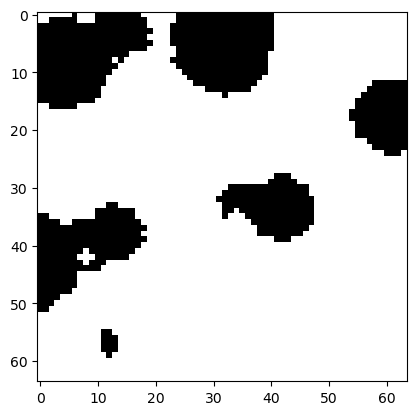

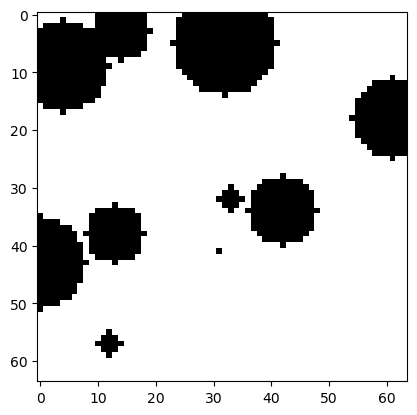

In [51]:
reconstruction = reconstruct_from_bps(bps_encoding, basis, 64)
plt.imshow(reconstruction, cmap='binary')
plt.show()
plt.imshow(grid, cmap='binary')

(16, 16)


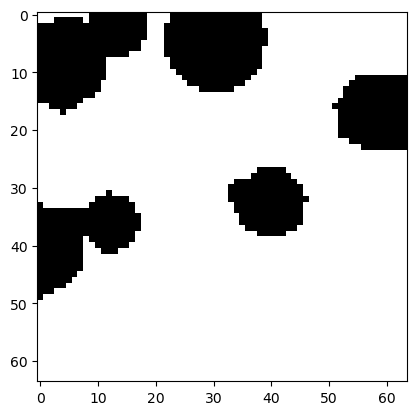

In [54]:
from scene_reconstruction_procedural import interpolate_distance_map, apply_threshold


print(bps_encoding.shape)
distance_map = interpolate_distance_map(bps_encoding, 16, 64)
predicted_grid= torch.from_numpy(apply_threshold(distance_map))

plt.imshow(predicted_grid, cmap = 'binary')

In [56]:
predicted_count = 0
reconstructed_count = 0

for i in range(64):
    for j in range(64):
        if predicted_grid[i][j] == grid[i][j]:
            predicted_count += 1
        if reconstruction[i][j] == grid[i][j]:
            reconstructed_count += 1

print('Circle Reconstruction: ', reconstructed_count/(64*64))
print('Bilinear Reconstruction: ', predicted_count/(64*64))

Circle Reconstruction:  0.974853515625
Bilinear Reconstruction:  0.93115234375
